# Imports

In [1]:
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
from torch.distributions import Categorical
from torch.utils.data import Dataset, Sampler, DataLoader
import multiprocessing as mp

import gym
import gym.spaces

import copy

from src.rl_environment import Environment
from src.graph_model import get_peo

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print (use_cuda)

def to_tensor(*args, **kwargs):
    return torch.Tensor(*args, **kwargs).to(device)

True


### PPO algorithm

In [3]:
env = Environment('inst_2x2_7_0.txt', square_index=True)
state_shape = (15, 15)

2018-11-23 16:37:21,483- INFO•	reading file inst_2x2_7_0.txt
2018-11-23 16:37:21,491- INFO•	There are 4 qubits in circuit
2018-11-23 16:37:21,493- INFO•	Generated graph with 10 nodes and 22 edges
2018-11-23 16:37:21,494- INFO•	last index contains from [9, 2, 5, 10]


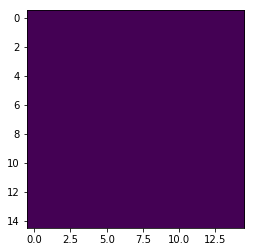

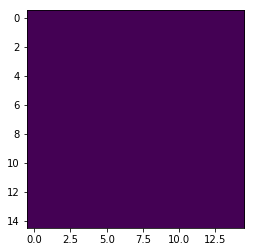

In [4]:
s = env.reset()
done = False
while not done:
    probs = np.ones(15) / 15
    mask = env.available_actions
    probs = probs * mask
    probs = probs / probs.sum()
    
    action = np.random.choice(15, p=probs)
    s, cost, done = env.step(action)
    plt.imshow(s)
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [5]:
from models.sequential import SequentialNet, name2nn
from models.utils import create_optimal_inner_init, out_init

In [6]:
class ConvNet(nn.Module):
    def __init__(
            self, output_size,
            conv_hiddens, linear_hiddens,
            conv_kwargs=None,
            state_shape=[15, 15], num_channels=1,
            activation_fn=nn.ReLU, norm_fn=None, bias=True):
        super().__init__()
        activation_fn = name2nn(activation_fn)
        norm_fn = name2nn(norm_fn)
        self.input_shape = [num_channels] + state_shape
        default_conv_kwargs = {
            "kernel_size": 3,
            "stride": 2,
            "padding": 0
        }
        conv_kwargs = conv_kwargs or default_conv_kwargs

        def conv_fn(f_in, f_out, bias=True):
            return nn.Conv2d(f_in, f_out, bias=bias, **conv_kwargs)

        self.conv_net = SequentialNet(
            hiddens=[num_channels] + conv_hiddens,
            layer_fn=conv_fn,
            activation_fn=activation_fn,
            norm_fn=None,
            bias=bias)
        hw = state_shape[0]
        padding = conv_kwargs.get("padding", 0)
        ksize = conv_kwargs["kernel_size"]
        stride = conv_kwargs.get("stride", 1)
        for i in range(len(conv_hiddens)):
            hw = (hw + 2 * padding - (ksize - 1) - 1) // stride + 1
        linear_input_size = conv_hiddens[-1] * hw ** 2
        self.linear_net = SequentialNet(
            hiddens=[linear_input_size] + linear_hiddens,
            layer_fn=nn.Linear,
            activation_fn=activation_fn,
            norm_fn=None,
            bias=bias)
        self.policy_net = SequentialNet(
            hiddens=[linear_hiddens[-1], output_size],
            layer_fn=nn.Linear,
            activation_fn=None,
            norm_fn=None,
            bias=True)
        inner_init = create_optimal_inner_init(nonlinearity=activation_fn)
        self.conv_net.apply(inner_init)
        self.linear_net.apply(inner_init)
        self.policy_net.apply(out_init)
        
    def forward(self, states):
        if len(states.shape) == 3:
            states = states[..., None]
        x = states.permute(0, 3, 1, 2)
        x = self.conv_net(x).view(states.shape[0], -1)
        x = self.linear_net(x)
        logits = self.policy_net(x)
        return logits
        

In [7]:
class Actor(ConvNet):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def forward(self, states, mask, with_dist=False):
        logits = super().forward(states)
        probs = nn.functional.softmax(logits, dim=-1)
        probs = (probs + 1e-6) * mask
        #probs = probs * mask
        probs = probs / probs.sum(dim=-1)[..., None]
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()
        if with_dist:
            return action, dist
        return action


class Critic(ConvNet):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def forward(self, states, with_log_pi=False):
        values = super().forward(states)
        return values

In [8]:
def play_episode(env, actor):
    states, actions, masks, rewards, dones = [], [], [], [], []
    s = env.reset()
    done = False
    
    worst_cost = 0
    
    while not done:
        states.append(s.tolist())
        
        mask = env.available_actions.copy()

        a, dist = actor.forward(
            to_tensor(s[None, :, :, None]),
            mask=to_tensor(mask[None, :]),
            with_dist=True)
        a = a.cpu().detach().numpy()[0]

        s, r, done = env.step(a)
        
        worst_cost = max(worst_cost, r)
        
        if done:
            reward = -worst_cost
        else:
            reward = 0
        
        actions.append(a)
        masks.append(mask.tolist())
        rewards.append(reward)
        dones.append(done)

    return states, actions, masks, rewards, dones

In [9]:
state_shape = (15, 15)
conv_hiddens=[32, 64, 64]
linear_hiddens = [256, 128]

actor = Actor(
    output_size=15,
    conv_hiddens=conv_hiddens,
    linear_hiddens=linear_hiddens).to(device) 
critic = Critic(
    output_size=1,
    conv_hiddens=conv_hiddens,
    linear_hiddens=linear_hiddens).to(device)

In [10]:
class BufferDataset(Dataset):
    def __init__(self, state_shape, max_size):
        self.max_size = max_size
        self.len = 0
        self.pointer = 0
        
        self.states = np.empty((self.max_size,) + state_shape, dtype=np.float32)
        self.actions = np.empty((self.max_size,), dtype=np.int32)
        self.masks = np.empty((self.max_size, 15), dtype=np.int32)
        self.returns = np.empty((self.max_size,), dtype=np.float32)
        self.values = np.empty((self.max_size,), dtype=np.float32)
        self.advantages = np.empty((self.max_size,), dtype=np.float32)
        self.log_pis = np.empty((self.max_size,), dtype=np.float32)

    def push_episode(self, episode):
        states, actions, masks, ret, val, adv, log_pi = episode
        episode_len = len(actions)
        self.len = min(self.len + episode_len, self.max_size)
        indices = np.arange(
            self.pointer, self.pointer + episode_len) % self.max_size
        self.states[indices] = states
        self.actions[indices] = actions
        self.masks[indices] = masks
        self.returns[indices] = ret
        self.values[indices] = val
        self.advantages[indices] = adv
        self.log_pis[indices] = log_pi
        self.pointer = (self.pointer + episode_len) % self.max_size

    def rescale_advantages(self):
        adv_centered = self.advantages[:self.len] - self.advantages[:self.len].mean()
        self.advantages[:self.len] = adv_centered / (self.advantages[:self.len].std() + 1e-6)

    def __getitem__(self, index):
        dct = {
            "state": self.states[index],
            "action": self.actions[index].astype(np.float32),
            "mask": self.masks[index].astype(np.float32),
            "return": self.returns[index],
            "value": self.values[index],
            "advantage": self.advantages[index],
            "log_pi": self.log_pis[index]
        }
        return dct

    def __len__(self):
        return self.len
        
        
class BufferSampler(Sampler):
    def __init__(self, buffer, num_mini_epochs):
        super().__init__(None)
        self.buffer = buffer
        self.num_mini_epochs = num_mini_epochs
        buffer_len = len(self.buffer)
        self.len = buffer_len * num_mini_epochs

        indices = []
        for i in range(num_mini_epochs):
            idx = np.arange(buffer_len)
            np.random.shuffle(idx)
            indices.append(idx)
        self.indices = np.concatenate(indices)

    def __iter__(self):
        return iter(self.indices)

    def __len__(self):
        return self.len

In [11]:
def create_gamma_matrix(tau, matrix_size):
    """
    Matrix of the following form
    --------------------
    1     y   y^2    y^3
    0     1     y    y^2
    0     0     1      y
    0     0     0      1
    --------------------
    for fast gae calculation
    """
    i = np.arange(matrix_size)
    j = np.arange(matrix_size)
    pow_ = i[None, :] - j[:, None]
    mat = np.power(tau, pow_) * (pow_ >= 0)
    return mat


class PPO_GAE:
    def __init__(
            self,
            actor, critic,
            gamma, gae_lambda=0.95,
            clip_eps=0.2,
            episode_len=1000,
            minibatch_size=32,
            num_mini_epochs=10,
            use_value_clipping=False,
            entropy_reg_coefficient=0.):
        self._device = device

        self.actor = actor.to(self._device)
        self.critic = critic.to(self._device)
        
        self.actor_optimizer = optim.Adam(
            self.actor.parameters(), lr=lr)
        self.critic_optimizer = optim.Adam(
            self.critic.parameters(), lr=lr)

        self.gae_lambda = gae_lambda
        self.gamma = gamma
        self.clip_eps = clip_eps
        self.episode_len = episode_len
        self.num_mini_epochs = num_mini_epochs
        self.minibatch_size = minibatch_size
        self.use_value_clipping = use_value_clipping
        self.entropy_reg_coefficient = entropy_reg_coefficient

        self.gam_lam_matrix = create_gamma_matrix(
            self.gamma * gae_lambda, episode_len)
        self.gam_matrix = create_gamma_matrix(
            self.gamma, episode_len)
        
    def to_tensor(self, *args, **kwargs):
        return torch.Tensor(*args, **kwargs).to(self._device)

    def evaluate_episode(self, states, actions, masks, rewards):
        states = self.to_tensor(states)
        actions = self.to_tensor(actions)
        masks = self.to_tensor(masks)
        rewards = np.array(rewards)

        ep_len = rewards.shape[0]
        values = torch.zeros((ep_len + 1, 1)).to(self._device)
        values[:ep_len] = self.critic(states)
        values = values.detach().cpu().numpy().reshape(-1)
        
        _, dist = self.actor(states, masks, with_dist=True)
        log_pis = dist.log_prob(actions)
        log_pis = log_pis.detach().cpu().numpy().reshape(-1)
        
        deltas = rewards + self.gamma * values[1:] - values[:-1]
        advantages = np.dot(self.gam_lam_matrix[:ep_len, :ep_len], deltas)
        returns = np.dot(self.gam_matrix[:ep_len, :ep_len], rewards)

        return [returns, values[:ep_len], advantages, log_pis]

    def train(self, batch):
        states, actions, masks, returns, values, advantages, log_pis = \
            batch["state"], batch["action"], batch["mask"], batch["return"], \
            batch["value"], batch["advantage"], batch["log_pi"]

        states = self.to_tensor(states)
        actions = self.to_tensor(actions)
        masks = self.to_tensor(masks)
        returns = self.to_tensor(returns)
        old_values = self.to_tensor(values)
        advantages = self.to_tensor(advantages)
        old_log_pi = self.to_tensor(log_pis)

        values_t = self.critic(states).squeeze()
        if self.use_value_clipping:
            values_clip = old_values + torch.clamp(
                values_t - old_values, -self.clip_eps, self.clip_eps)
            val_loss1 = (values_t - returns).pow(2)
            val_loss2 = (values_clip - returns).pow(2)
            value_loss = 0.5 * torch.max(val_loss1, val_loss2).mean()
        else:
            value_loss = 0.5 * (values_t - returns).pow(2).mean()

        # actor loss
        _, dist = self.actor(states, masks, with_dist=True)
        log_pi = dist.log_prob(actions)

        ratio = torch.exp(log_pi - old_log_pi)
        surr1 = advantages * ratio
        surr2 = advantages * torch.clamp(
            ratio, 1.0 - self.clip_eps, 1.0 + self.clip_eps)
        policy_loss = -torch.min(surr1, surr2).mean()

        entropy = -(torch.exp(log_pi) * log_pi).mean()
        entropy_reg = self.entropy_reg_coefficient * entropy
        policy_loss = policy_loss + entropy_reg

        # actor update
        self.actor_update(policy_loss)
        # critic update
        self.critic_update(value_loss)

        metrics = {
            "loss_actor": policy_loss.item(),
            "loss_critic": value_loss.item()
        }
        return metrics
        
    def actor_update(self, loss):
        self.actor.zero_grad()
        self.actor_optimizer.zero_grad()
        loss.backward()
        self.actor_optimizer.step()

    def critic_update(self, loss):
        self.critic.zero_grad()
        self.critic_optimizer.zero_grad()
        loss.backward()
        self.critic_optimizer.step()

In [13]:
batch_size = 2000
lr = 1e-3

num_mini_epochs = 6
minibatch_size = 500

state_shape = (15, 15)
conv_hiddens=[64, 64]
linear_hiddens = [128, 128]

actor = Actor(
    output_size=15,
    conv_hiddens=conv_hiddens,
    linear_hiddens=linear_hiddens).to(device) 
critic = Critic(
    output_size=1,
    conv_hiddens=conv_hiddens,
    linear_hiddens=linear_hiddens).to(device)

algo = PPO_GAE(
    actor, critic,
    gamma=0.99, gae_lambda=0.95,
    minibatch_size=minibatch_size,
    num_mini_epochs=num_mini_epochs)

In [14]:
num_episodes = 0
avg_reward = 0
sum_actor_loss = 0
sum_critic_loss = 0

actor_losses = []
critic_losses = []
total_rewards = []
episode_rewards = []

for epoch in range(1, 10000):
    
    buffer = BufferDataset(state_shape, batch_size)

    while len(buffer) < batch_size:
        episode = play_episode(env, algo.actor)
        ret, val, adv, log_pi = algo.evaluate_episode(
            episode[0], episode[1], episode[2], episode[3])
        data = [episode[0], episode[1], episode[2], ret, val, adv, log_pi]
        buffer.push_episode(data)
        episode_rewards.append(np.sum(episode[3]))
        num_episodes += 1
    buffer.rescale_advantages()
        
    sampler = BufferSampler(
        buffer=buffer,
        num_mini_epochs=num_mini_epochs)
    loader = DataLoader(
        dataset=buffer,
        batch_size=minibatch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=torch.cuda.is_available(),
        sampler=sampler)
        
    actor_loss = []
    critic_loss = []
    for i, batch in enumerate(loader):
        metrics = algo.train(batch)
        actor_loss.append(metrics["loss_actor"])
        critic_loss.append(metrics["loss_critic"])
    sum_actor_loss += np.mean(actor_loss)
    sum_critic_loss += np.mean(critic_loss)
    
    if epoch % 1 == 0:
        avg_rew = np.mean(episode_rewards)
        avg_actor_loss = sum_actor_loss
        avg_critic_loss = sum_critic_loss
        print ("Actor loss:         ", avg_actor_loss)
        print ("Critic loss:        ", avg_critic_loss)
        print ("Average reward:     ", avg_rew)
        print ("Num episodes:       ", num_episodes)
        print ("--------------------------------------------")
        actor_losses.append(avg_actor_loss)
        critic_losses.append(avg_critic_loss)
        total_rewards.append(avg_rew)
        sum_actor_loss = 0
        sum_critic_loss = 0
        episode_rewards = []
    num_episodes = 0

Actor loss:          -0.024126710147053625
Critic loss:         9039.743133544922
Average reward:      -146.56
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03439220520279681
Critic loss:         3580.3063049316406
Average reward:      -151.28
Num episodes:        200
--------------------------------------------
Actor loss:          -0.037231347040991146
Critic loss:         2446.549830118815
Average reward:      -146.48
Num episodes:        200
--------------------------------------------
Actor loss:          -0.04185892747288259
Critic loss:         2603.649586995443
Average reward:      -149.68
Num episodes:        200
--------------------------------------------
Actor loss:          -0.041647211202265076
Critic loss:         1534.5951182047527
Average reward:      -142.08
Num episodes:        200
--------------------------------------------
Actor loss:          -0.04683079706349721
Critic loss:         1742.9422149658203
Average rewar

Actor loss:          -0.02911065313128347
Critic loss:         530.9786313374838
Average reward:      -103.2
Num episodes:        200
--------------------------------------------
Actor loss:          -0.0361367110235733
Critic loss:         476.1509208679199
Average reward:      -101.96
Num episodes:        200
--------------------------------------------
Actor loss:          -0.031191348334080733
Critic loss:         514.1264101664225
Average reward:      -104.92
Num episodes:        200
--------------------------------------------
Actor loss:          -0.025039914403654013
Critic loss:         563.5767720540365
Average reward:      -103.12
Num episodes:        200
--------------------------------------------
Actor loss:          -0.02675776632774311
Critic loss:         652.6405537923177
Average reward:      -104.88
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03414037784386892
Critic loss:         290.2973569234212
Average reward:    

Actor loss:          -0.036187341601665445
Critic loss:         274.3781153361003
Average reward:      -94.68
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03844525579673549
Critic loss:         379.14330037434894
Average reward:      -94.24
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03154552658088505
Critic loss:         544.7560984293619
Average reward:      -95.84
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03642569652341384
Critic loss:         407.79158147176105
Average reward:      -94.04
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03977256860343914
Critic loss:         251.13813273111978
Average reward:      -90.24
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03180629244889133
Critic loss:         343.4867757161458
Average reward:     

Actor loss:          -0.033325554696299754
Critic loss:         435.0713946024577
Average reward:      -90.92
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03347354813013226
Critic loss:         335.9254404703776
Average reward:      -90.56
Num episodes:        200
--------------------------------------------
Actor loss:          -0.035287259883868195
Critic loss:         465.795706431071
Average reward:      -92.36
Num episodes:        200
--------------------------------------------
Actor loss:          -0.037045363016659394
Critic loss:         452.9924774169922
Average reward:      -94.44
Num episodes:        200
--------------------------------------------
Actor loss:          -0.034031596539231636
Critic loss:         528.2494227091471
Average reward:      -93.0
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03807345393579453
Critic loss:         251.5267874399821
Average reward:      -

Actor loss:          -0.041063935263082385
Critic loss:         281.3529733022054
Average reward:      -82.96
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03640435472577034
Critic loss:         279.6740582784017
Average reward:      -83.0
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03868755048218494
Critic loss:         200.35679054260254
Average reward:      -81.92
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03442407577919463
Critic loss:         315.8892714182536
Average reward:      -83.76
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03452295266712705
Critic loss:         335.0393594106038
Average reward:      -83.52
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03609280241653323
Critic loss:         282.67951583862305
Average reward:      -

Actor loss:          -0.03671891655540094
Critic loss:         331.9026056925456
Average reward:      -78.2
Num episodes:        200
--------------------------------------------
Actor loss:          -0.044894929024546094
Critic loss:         193.38634808858237
Average reward:      -73.32
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03795919175596888
Critic loss:         236.17636426289877
Average reward:      -75.84
Num episodes:        200
--------------------------------------------
Actor loss:          -0.04128031999183198
Critic loss:         204.7645632425944
Average reward:      -75.16
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03662431791478108
Critic loss:         316.7308540344238
Average reward:      -79.64
Num episodes:        200
--------------------------------------------
Actor loss:          -0.037979500950314105
Critic loss:         269.98720359802246
Average reward:     

Actor loss:          -0.039581493862594165
Critic loss:         211.444065729777
Average reward:      -71.44
Num episodes:        200
--------------------------------------------
Actor loss:          -0.034614934212489366
Critic loss:         274.6730257670085
Average reward:      -71.72
Num episodes:        200
--------------------------------------------
Actor loss:          -0.031153001512090366
Critic loss:         283.70187123616535
Average reward:      -71.04
Num episodes:        200
--------------------------------------------
Actor loss:          -0.039163163068375674
Critic loss:         273.10674476623535
Average reward:      -76.08
Num episodes:        200
--------------------------------------------
Actor loss:          -0.0417060612332231
Critic loss:         174.9991372426351
Average reward:      -71.92
Num episodes:        200
--------------------------------------------
Actor loss:          -0.039639550319407135
Critic loss:         236.86755434672037
Average reward:   

Actor loss:          -0.03676032559693946
Critic loss:         219.4599412282308
Average reward:      -69.68
Num episodes:        200
--------------------------------------------
Actor loss:          -0.04006576041380564
Critic loss:         173.36288770039877
Average reward:      -69.32
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03519153747280749
Critic loss:         204.0969581604004
Average reward:      -68.92
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03719747039334228
Critic loss:         217.03882535298666
Average reward:      -69.6
Num episodes:        200
--------------------------------------------
Actor loss:          -0.035161503053435204
Critic loss:         260.8678773244222
Average reward:      -71.88
Num episodes:        200
--------------------------------------------
Actor loss:          -0.0413985373985876
Critic loss:         221.6009953816732
Average reward:      -7

Actor loss:          -0.03880867106878819
Critic loss:         206.95395469665527
Average reward:      -67.68
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03486233144455279
Critic loss:         180.10246213277182
Average reward:      -65.84
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03087689708263497
Critic loss:         281.9793872833252
Average reward:      -66.96
Num episodes:        200
--------------------------------------------
Actor loss:          -0.036184074983642255
Critic loss:         219.21476682027182
Average reward:      -67.52
Num episodes:        200
--------------------------------------------
Actor loss:          -0.028863802096263196
Critic loss:         271.489216486613
Average reward:      -68.4
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03834395227022469
Critic loss:         192.26490592956543
Average reward:     

Actor loss:          -0.037325033937425665
Critic loss:         231.45500500996908
Average reward:      -68.04
Num episodes:        200
--------------------------------------------
Actor loss:          -0.037222792161628604
Critic loss:         172.08291625976562
Average reward:      -64.64
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03979151737560945
Critic loss:         160.50689824422201
Average reward:      -65.84
Num episodes:        200
--------------------------------------------
Actor loss:          -0.034599447797518224
Critic loss:         201.3923823038737
Average reward:      -65.36
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03673631406854838
Critic loss:         211.67386118570963
Average reward:      -69.16
Num episodes:        200
--------------------------------------------
Actor loss:          -0.034719368845496014
Critic loss:         216.84840202331543
Average reward:

Actor loss:          -0.03247739097181087
Critic loss:         195.9051856994629
Average reward:      -67.32
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03328906727862583
Critic loss:         205.13655153910318
Average reward:      -63.96
Num episodes:        200
--------------------------------------------
Actor loss:          -0.038333873031660914
Critic loss:         196.38227907816568
Average reward:      -65.12
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03227572570782892
Critic loss:         234.91594441731772
Average reward:      -65.32
Num episodes:        200
--------------------------------------------
Actor loss:          -0.027135146966126438
Critic loss:         170.8836758931478
Average reward:      -62.96
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03523358427628409
Critic loss:         136.01910622914633
Average reward:   

Actor loss:          -0.03224326700243788
Critic loss:         222.6424102783203
Average reward:      -68.04
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03718292593354514
Critic loss:         190.9321263631185
Average reward:      -64.4
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03115704024336689
Critic loss:         204.80408096313477
Average reward:      -66.48
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03149124541717659
Critic loss:         265.7462450663249
Average reward:      -67.44
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03290928993374109
Critic loss:         201.90404001871744
Average reward:      -63.56
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03409623856471929
Critic loss:         263.371129989624
Average reward:      -66

Actor loss:          -0.03105074169191842
Critic loss:         204.28841018676758
Average reward:      -65.96
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03339936046177172
Critic loss:         173.30588150024414
Average reward:      -64.16
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03531735713719778
Critic loss:         153.79479058583578
Average reward:      -62.16
Num episodes:        200
--------------------------------------------
Actor loss:          -0.02830813832891484
Critic loss:         235.56500434875488
Average reward:      -63.64
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03347855410902412
Critic loss:         153.88697973887125
Average reward:      -61.88
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03316743188770488
Critic loss:         220.93932342529297
Average reward:   

Actor loss:          -0.03245699058364456
Critic loss:         172.38913790384927
Average reward:      -64.32
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03424595150863752
Critic loss:         227.76880009969076
Average reward:      -65.36
Num episodes:        200
--------------------------------------------
Actor loss:          -0.028296188759365275
Critic loss:         172.57370249430338
Average reward:      -59.48
Num episodes:        200
--------------------------------------------
Actor loss:          -0.029276003032767523
Critic loss:         187.15024757385254
Average reward:      -62.32
Num episodes:        200
--------------------------------------------
Actor loss:          -0.028873670458172757
Critic loss:         178.3780549367269
Average reward:      -60.36
Num episodes:        200
--------------------------------------------
Actor loss:          -0.036417248459959715
Critic loss:         127.64661916097005
Average reward:

Actor loss:          -0.027930323830029618
Critic loss:         125.06231021881104
Average reward:      -59.56
Num episodes:        200
--------------------------------------------
Actor loss:          -0.02721153291774196
Critic loss:         106.63762124379475
Average reward:      -58.32
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03060299302645338
Critic loss:         138.54537932078043
Average reward:      -59.08
Num episodes:        200
--------------------------------------------
Actor loss:          -0.023493777681627154
Critic loss:         130.96991952260336
Average reward:      -59.2
Num episodes:        200
--------------------------------------------
Actor loss:          -0.02428542453950892
Critic loss:         205.17308870951334
Average reward:      -59.64
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03179090771057721
Critic loss:         107.39416376749675
Average reward:  

Actor loss:          -0.025318058595682185
Critic loss:         138.86551157633463
Average reward:      -58.52
Num episodes:        200
--------------------------------------------
Actor loss:          -0.02723832244131093
Critic loss:         132.80952962239584
Average reward:      -58.04
Num episodes:        200
--------------------------------------------
Actor loss:          -0.02186091636758647
Critic loss:         187.60704612731934
Average reward:      -58.68
Num episodes:        200
--------------------------------------------
Actor loss:          -0.025895191720337607
Critic loss:         127.21237468719482
Average reward:      -57.76
Num episodes:        200
--------------------------------------------
Actor loss:          -0.025596170424250886
Critic loss:         167.9279063542684
Average reward:      -59.76
Num episodes:        200
--------------------------------------------
Actor loss:          -0.028502163171651773
Critic loss:         139.26117070515951
Average reward:

Actor loss:          -0.020072162355063483
Critic loss:         100.0480941136678
Average reward:      -56.12
Num episodes:        200
--------------------------------------------
Actor loss:          -0.01962854020530358
Critic loss:         108.48953692118327
Average reward:      -55.96
Num episodes:        200
--------------------------------------------
Actor loss:          -0.022938070113013964
Critic loss:         104.52470016479492
Average reward:      -55.88
Num episodes:        200
--------------------------------------------
Actor loss:          -0.025798867767055828
Critic loss:         127.56374740600586
Average reward:      -57.88
Num episodes:        200
--------------------------------------------
Actor loss:          -0.025073638687899802
Critic loss:         150.70192273457846
Average reward:      -58.68
Num episodes:        200
--------------------------------------------
Actor loss:          -0.02454003175565352
Critic loss:         100.92570400238037
Average reward:

Actor loss:          -0.02488451896351762
Critic loss:         89.23171488444011
Average reward:      -56.52
Num episodes:        200
--------------------------------------------
Actor loss:          -0.02288024560160314
Critic loss:         124.54818693796794
Average reward:      -56.36
Num episodes:        200
--------------------------------------------
Actor loss:          -0.025128570559900254
Critic loss:         112.57888158162434
Average reward:      -56.92
Num episodes:        200
--------------------------------------------
Actor loss:          -0.019794852356426418
Critic loss:         122.71062564849854
Average reward:      -57.12
Num episodes:        200
--------------------------------------------
Actor loss:          -0.024055515590589494
Critic loss:         81.21144819259644
Average reward:      -54.72
Num episodes:        200
--------------------------------------------
Actor loss:          -0.020800279899655532
Critic loss:         158.38683446248373
Average reward: 

Actor loss:          -0.02545408888545353
Critic loss:         90.07297039031982
Average reward:      -55.12
Num episodes:        200
--------------------------------------------
Actor loss:          -0.0251851251135425
Critic loss:         206.4363644917806
Average reward:      -60.24
Num episodes:        200
--------------------------------------------
Actor loss:          -0.021912226802669466
Critic loss:         136.86729780832925
Average reward:      -57.52
Num episodes:        200
--------------------------------------------
Actor loss:          -0.025716181999693315
Critic loss:         63.76467227935791
Average reward:      -54.44
Num episodes:        200
--------------------------------------------
Actor loss:          -0.023440701950069826
Critic loss:         100.0350383122762
Average reward:      -54.68
Num episodes:        200
--------------------------------------------
Actor loss:          -0.022261918503014993
Critic loss:         65.66563892364502
Average reward:     

Actor loss:          -0.020148553429559495
Critic loss:         162.10616302490234
Average reward:      -58.32
Num episodes:        200
--------------------------------------------
Actor loss:          -0.024310161747659247
Critic loss:         114.50863520304362
Average reward:      -57.12
Num episodes:        200
--------------------------------------------
Actor loss:          -0.02165541706441824
Critic loss:         112.2274154027303
Average reward:      -58.36
Num episodes:        200
--------------------------------------------
Actor loss:          -0.025511197784605127
Critic loss:         101.33695983886719
Average reward:      -55.96
Num episodes:        200
--------------------------------------------
Actor loss:          -0.025914292957168072
Critic loss:         149.08735434214273
Average reward:      -57.6
Num episodes:        200
--------------------------------------------
Actor loss:          -0.01623999056998097
Critic loss:         133.26881980895996
Average reward: 

Process Process-1833:
Process Process-1834:
Traceback (most recent call last):
  File "/home/agrinchuk/miniconda3/envs/opensim-rl/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/agrinchuk/miniconda3/envs/opensim-rl/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/agrinchuk/miniconda3/envs/opensim-rl/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 110, in _worker_loop
    data_queue.put((idx, samples))
Traceback (most recent call last):
  File "/home/agrinchuk/miniconda3/envs/opensim-rl/lib/python3.6/multiprocessing/queues.py", line 341, in put
    obj = _ForkingPickler.dumps(obj)
  File "/home/agrinchuk/miniconda3/envs/opensim-rl/lib/python3.6/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/home/agrinchuk/miniconda3/envs/opensim-rl/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 194, in 

KeyboardInterrupt: 

  File "/home/agrinchuk/miniconda3/envs/opensim-rl/lib/python3.6/multiprocessing/resource_sharer.py", line 77, in register
    self._start()
  File "/home/agrinchuk/miniconda3/envs/opensim-rl/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 110, in _worker_loop
    data_queue.put((idx, samples))
  File "/home/agrinchuk/miniconda3/envs/opensim-rl/lib/python3.6/multiprocessing/queues.py", line 341, in put
    obj = _ForkingPickler.dumps(obj)
  File "/home/agrinchuk/miniconda3/envs/opensim-rl/lib/python3.6/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/home/agrinchuk/miniconda3/envs/opensim-rl/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 194, in reduce_storage
    df = multiprocessing.reduction.DupFd(fd)
  File "/home/agrinchuk/miniconda3/envs/opensim-rl/lib/python3.6/multiprocessing/reduction.py", line 191, in DupFd
    return resource_sharer.DupFd(fd)
  File "/home/agrinchuk/miniconda3/envs/opensim-rl

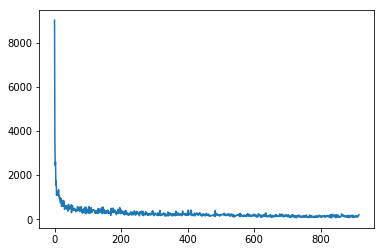

In [15]:
plt.plot(critic_losses)

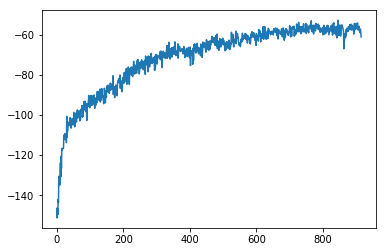

In [16]:
plt.plot(total_rewards)

In [ ]:
total_rewards[-20:]

In [ ]:
plt.plot(critic_losses)

In [ ]:
plt.plot(total_rewards)